## Libraries

In [5]:
import os
from keras_unet_collection import models, utils
import tensorflow as tf
import cv2
import keras
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt
from UQ_models.attn_multi_model import r2_unet, mc_att_unet
from UQ_models.attn_multi_model import att_unet as att_unet_org
from UQ_models.att_dense_unet import attn_dense_unet, mc_attn_dense_unet
from UQ_models.unet_MC import multi_unet_model as mc_unet_model
from UQ_models.unet import unet_model
from UQ_models.Dense_UNet import mc_dense_unet, dense_unet
from UQ_models.att_fpa import att_unet
import gdown
import datetime
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import requests
# Notifications config:
url_notif = 'https://api.pushcut.io/nijldnK5Ud5uQXRJI0v_G/notifications/Training%20ended'
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
tf.__version__

'2.8.0'

In [7]:
df_final = pd.DataFrame()

# if not os.path.exists('logs'):
#     os.makedirs('logs')
# if not os.path.exists('images/plots'):
#     os.makedirs('images/plots')
# if not os.path.exists('weights'):
#     os.makedirs('weights')


## Dataset

In [9]:
import os
main = os.getcwd()

In [10]:
train = tf.data.Dataset.load(main+'/dataset_tensor/train/')
test = tf.data.Dataset.load(main+'/dataset_tensor/test/')
val = tf.data.Dataset.load(main+'/dataset_tensor/val/')
dataset_train= train.concatenate(val)
dataset = dataset_train.concatenate(test)

AttributeError: type object 'DatasetV2' has no attribute 'load'

In [7]:
test_len = len(test)
test_len

349

In [8]:
del train, val

In [9]:
IMG_W = 256
IMG_H = 256
IMG_CH = 1
N_CLASSES = 5
def process(path1, path2):  
    img=tf.io.read_file(path1)
    img=tf.image.decode_jpeg(img, channels=1)
    img=tf.image.resize(img,[IMG_W,IMG_H])
    img = tf.math.l2_normalize(img, axis=1)
    # img = tf.squeeze(img)

    msk = tf.io.read_file(path2)
    msk=tf.image.decode_png(msk)
    msk=tf.image.resize(msk,[IMG_W,IMG_H])
    msk = tf.squeeze(msk)
    msk = tf.cast(msk, tf.int32)
    msk = tf.one_hot(indices=msk, depth=N_CLASSES, axis=-1)
    
    img.set_shape([256,256,1])
    msk.set_shape([256,256,5])

    return img, msk

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
test = test.map(process, num_parallel_calls=AUTOTUNE)
dataset_train = dataset_train.map(process, num_parallel_calls=AUTOTUNE)

In [11]:
BATCH_SIZE = 12

test = test.cache()
test = test.batch(BATCH_SIZE)
test = test.prefetch(AUTOTUNE)

train = dataset_train.cache()
train = train.batch(BATCH_SIZE)
train = train.prefetch(AUTOTUNE)

## Model

### Parameters

In [12]:
LR = 0.0001
EPOCHS = 100
optim = keras.optimizers.Adam(LR)
loss = keras.losses.categorical_crossentropy
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
focal_loss = sm.losses.BinaryFocalLoss() if N_CLASSES == 1 else sm.losses.CategoricalFocalLoss()

In [ ]:
model = models.att_unet_2d((256, 256, 1), filter_num=[64, 128, 256, 512, 1024], n_labels=5, stack_num_down=2, stack_num_up=2, activation='ReLU', 
                atten_activation='ReLU', attention='multiply', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
                backbone=None, weights=None, freeze_backbone=False, freeze_batch_norm=True, name='attunet')
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics =[tf.keras.metrics.MeanIoU(num_classes=5), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])

In [ ]:
# UNET Montecarlo Dropout

model = mc_unet_model(n_classes=5, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics = metrics)
name = 'mc_unet_model'
folder = 'MC_COMPARISON/UNET'
# model.summary()

In [ ]:
# UNET

model = unet_model(n_classes=5, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics = metrics)
name = 'unet_model'
folder = 'MC_COMPARISON/UNET'
# model.summary()

In [ ]:
# ATTN UNET PYRAMIDAL
model = att_unet(img_h=256, img_w=256, img_ch=1, n_label=5, data_format='channels_last')
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics = metrics)
name = 'fpa_unet_model'
folder = 'FPA'
# model.summary()

In [ ]:
# ATTN UNET 
model = att_unet_org(img_h=256, img_w=256, img_ch=1, n_label=5, data_format='channels_last')
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics = metrics)
name = 'attn_unet_model'
folder = 'MC_COMPARISON/ATTN'
# model.summary()

In [ ]:
# MC ATTN UNET 
model = mc_att_unet(img_h=256, img_w=256, img_ch=1, n_label=5, data_format='channels_last')
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics = metrics)
name = 'mc_attn_unet_model'
folder = 'MC_COMPARISON/ATTN'
# model.summary()

In [ ]:
# Dense UNet 
model = dense_unet(input_shape=(256, 256, 1), num_classes=5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics = metrics)
name = 'dense_unet_model'
folder = 'MC_COMPARISON/DenseUNet'

In [ ]:
# MC Dense UNet 
model = mc_dense_unet(input_shape=(256, 256, 1), num_classes=5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics = metrics)
name = 'mc_dense_unet_model'
folder = 'MC_COMPARISON/DenseUNet'

In [ ]:
# Attn Dense UNet 
model = attn_dense_unet(input_shape=(256, 256, 1), num_classes=5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics = metrics)
name = 'attn_dense_unet_model'
folder = 'MC_COMPARISON/AttnDenseUNet'

In [16]:
# MC Attn Dense UNet 
model = mc_attn_dense_unet(input_shape=(256, 256, 1), num_classes=5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optim, metrics = metrics)
name = 'mc_attn_dense_unet_model'
folder = 'MC_COMPARISON/AttnDenseUNet'

In [17]:
if not os.path.exists(folder):
    os.makedirs(folder)

# Callbacks
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, 
                                   patience=10, restore_best_weights=True)
log_dir ="logs/unet/fit/" + name+ '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks= [es, tensorboard_callback, keras.callbacks.ModelCheckpoint(
                    filepath=(f'{folder}/{name}_best.hdf5'),
                    monitor='val_loss', save_best_only=True, mode='min')],

## Train

In [ ]:
#Training
history = model.fit(
    train, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    validation_data=test)

# Generate generalization metrics
scores = model.evaluate(test, verbose=0)
print(f'Scores: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]};\
      {model.metrics_names[2]} of {scores[2]}')

### Send notification to iPhone ###
notif = requests.post(url=url_notif)

# serialize model to json
json_model = model.to_json()#save the model architecture to JSON file
with open(f'{folder}/{name}.json', 'w') as json_file:
    json_file.write(json_model)
    
model.save(f'{folder}/{name}.h5')
!sudo shutdown -h now


Epoch 1/100
159/262 [=================>............] - ETA: 16s - loss: 0.1937 - iou_score: 0.3033 - f1-score: 0.3082

In [ ]:
# !sudo shutdown -h now

# Uncertainty 

In [13]:
df_final = pd.DataFrame()

In [63]:
df_entropy = pd.DataFrame()

In [23]:
df_final = pd.read_csv('MC_COMPARISON/metrics_T50.csv')  

## Load Model

In [25]:
import json
from tensorflow.keras.models import load_model, model_from_json
import segmentation_models as sm
from mcdropout import MCDropout
from tensorflow.keras.layers import Dropout
name = 'mc_attn_unet_model'
folder = 'MC_COMPARISON/ATTN/'
with open(f'{folder}/{name}.json', 'r') as json_file:
    model = model_from_json(json_file.read(), custom_objects={"iou_score": sm.metrics.IOUScore(threshold=0.5),
                                                        "f1-score": sm.metrics.FScore(threshold=0.5), 
                                                        "MCDropout": MCDropout(Dropout)})
    


model.load_weights(f'{folder}/{name}.h5')
model.compile(optim, loss, metrics)

## Evaluate 'T' times

In [15]:
from tqdm import tqdm

In [24]:
losses = []
ious = []
f1s = []
T = 50
for i in tqdm(range(T)):
    scores = model.evaluate(test, verbose = 0)
    losses.append(scores[0])
    ious.append(scores[1])
    f1s.append(scores[2])
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_f1 = np.mean(f1s)


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


In [25]:

# Creating the first Dataframe using dictionary
df_temp = pd.DataFrame({"model": [name],
                        "iou":[mean_iou],
                        "f1":[mean_f1],
                        "loss":[mean_loss]})
 
# for appending df2 at the end of df1
df_final = df_final.append(df_temp, ignore_index = True)
df_final


,model,iou,f1,loss
0,UNet,0.616940,0.694878,0.015129
1,Attention-UNet,0.701022,0.777807,0.014420
2,Dense-UNet,0.732276,0.805393,0.013867
3,Attention-Dense-UNet,0.722363,0.795627,0.013470
4,mc_attn_dense_unet_model,0.733239,0.805721,0.013619


In [29]:
df_final['model'] = df_final['model'].replace(['mc_unet_model'], 'UNet')
df_final['model'] = df_final['model'].replace(['mc_attn_unet_model'], 'Attention-UNet')
df_final['model'] = df_final['model'].replace(['mc_dense_unet_model'], 'Dense-UNet')
df_final['model'] = df_final['model'].replace(['mc_attn_dense_unet_model'], 'Attention-Dense-UNet')

,model,iou,f1,loss
0,UNet,0.616940,0.694878,0.015129
1,Attention-UNet,0.701022,0.777807,0.014420
2,Dense-UNet,0.732276,0.805393,0.013867
4,Attention-Dense-UNet,0.733239,0.805721,0.013619


In [30]:
df_final = df_final.set_index('model')
df_final

,iou,f1,loss
model,,,
UNet,0.616940,0.694878,0.015129
Attention-UNet,0.701022,0.777807,0.014420
Dense-UNet,0.732276,0.805393,0.013867
Attention-Dense-UNet,0.733239,0.805721,0.013619


In [31]:
df_final.to_csv('MC_COMPARISON/metrics_T50.csv')

## Entropy

In [16]:
def compute_entropy(predictive_prob):
    entropy_func = lambda x: -1 * np.sum(np.log(x + np.finfo(np.float32).eps) * x, axis=3)
    return entropy_func(predictive_prob)

### T=1

In [ ]:
T = 1
N_class = 5
predictive_prob_total = np.zeros((test_len, 256, 256, N_class))
for i in range(T):
    predictive_prob = model.predict(test, verbose=0)
    if (type(predictive_prob) is list):# some models may return logit, segmap
        predictive_prob = predictive_prob[1]
    predictive_prob_total += predictive_prob

pred_prob_avg_1 = predictive_prob_total / (T * 1.0)
entropy_1 = compute_entropy(pred_prob_avg_1)

test_1_argmax = np.argmax(pred_prob_avg_1, axis=3)


### T=20

In [ ]:
T = 20
N_class = 5
predictive_prob_total = np.zeros((test_len, 256, 256, N_class))
for i in range(T):
    predictive_prob = model.predict(test, verbose=0)
    if (type(predictive_prob) is list):# some models may return logit, segmap
        predictive_prob = predictive_prob[1]
    predictive_prob_total += predictive_prob

pred_prob_avg_20 = predictive_prob_total / (T * 1.0)
entropy_20 = compute_entropy(pred_prob_avg_20)

test_20_argmax = np.argmax(pred_prob_avg_20, axis=3)


### T=50

In [26]:
T = 50
N_class = 5
predictive_prob_total = np.zeros((test_len, 256, 256, N_class))
for i in tqdm(range(T)):
    predictive_prob = model.predict(test, verbose=0)
    if (type(predictive_prob) is list):# some models may return logit, segmap
        predictive_prob = predictive_prob[1]
    predictive_prob_total += predictive_prob

entropy_whole = compute_entropy(pred_prob_avg_50)
test_50_argmax = np.argmax(pred_prob_avg_50, axis=3)


100%|██████████| 50/50 [02:17<00:00,  2.75s/it]


In [60]:
pred_prob_avg_all = predictive_prob_total / (T * 1.0)
pred_prob_avg_gland = predictive_prob_total[:,:,:,1:] / (T * 1.0)
pred_prob_avg_cz = np.expand_dims(predictive_prob_total[:,:,:,1] / (T * 1.0), axis=-1)
pred_prob_avg_pz = np.expand_dims(predictive_prob_total[:,:,:,2] / (T * 1.0), axis=-1)
pred_prob_avg_tz = np.expand_dims(predictive_prob_total[:,:,:,3] / (T * 1.0), axis=-1)
pred_prob_avg_tum = np.expand_dims(predictive_prob_total[:,:,:,4] / (T * 1.0), axis=-1)

entropy_all = compute_entropy(pred_prob_avg_all)
entropy_gland = compute_entropy(pred_prob_avg_gland)
entropy_cz = compute_entropy(pred_prob_avg_cz)
entropy_pz = compute_entropy(pred_prob_avg_pz)
entropy_tz = compute_entropy(pred_prob_avg_tz)
entropy_tum = compute_entropy(pred_prob_avg_tum)

test_argmax_all = np.argmax(pred_prob_avg_all, axis=3)
test_argmax_gland = np.argmax(pred_prob_avg_gland, axis=3)

test_cz = pred_prob_avg_cz[:,:,:,0]
test_pz = pred_prob_avg_pz[:,:,:,0]
test_tz = pred_prob_avg_tz[:,:,:,0]
test_tum = pred_prob_avg_tum[:,:,:,0]

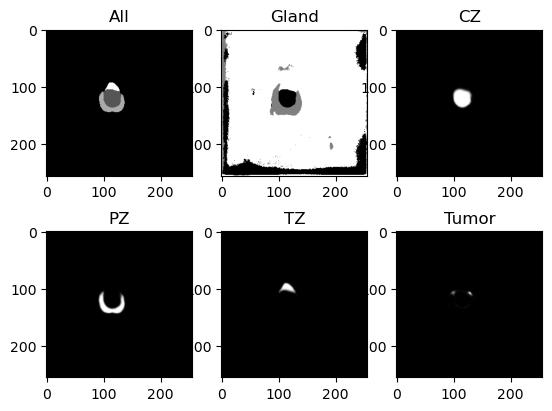

In [61]:
i=100
plt.subplot(231)
plt.title('All')
plt.imshow(test_argmax_all[i], cmap='gray')
plt.subplot(232)
plt.title('Gland')
plt.imshow(test_argmax_gland[i], cmap='gray')
plt.subplot(233)
plt.title('CZ')
plt.imshow(test_cz[i], cmap='gray')
plt.subplot(234)
plt.title('PZ')
plt.imshow(test_pz[i], cmap='gray')
plt.subplot(235)
plt.title('TZ')
plt.imshow(test_tz[i], cmap='gray')
plt.subplot(236)
plt.title('Tumor')
plt.imshow(test_tum[i], cmap='gray')

In [64]:
mean_entropy_all = np.mean(entropy_all)
mean_entropy_gland = np.mean(entropy_gland)
mean_entropy_cz = np.mean(entropy_cz)
mean_entropy_pz = np.mean(entropy_pz)
mean_entropy_tz = np.mean(entropy_tz)
mean_entropy_tum = np.mean(entropy_tum)

df_temp = pd.DataFrame({"model": [name],
                        "all":[mean_entropy_all],
                        "gland":[mean_entropy_gland],
                        "cz": [mean_entropy_cz],
                        "pz": [mean_entropy_pz],
                        "tz": [mean_entropy_tz],
                        "tum": [mean_entropy_tum],})

df_entropy = df_entropy.append(df_temp, ignore_index = True)
df_entropy


,model,all,gland,cz,pz,tz,tum
0,mc_attn_unet_model,0.010929,0.00662,0.002118,0.002679,0.000903,0.00092


### Prediction Plots

In [ ]:
plt.figure(dpi=200)
plt.subplot(1,3,1)
plt.title('One prediction')
plt.imshow(test_1_argmax[100], cmap='jet')
plt.subplot(1,3,2)
plt.title('Avg of 20 predictions')
plt.imshow(test_20_argmax[100], cmap='jet')
plt.subplot(1,3,3)
plt.title(f'Avg of 50 preds')
plt.imshow(test_50_argmax[100], cmap='jet')

### Uncertainty Map

In [ ]:
plt.figure(dpi=300)
plt.subplot(1,3,1)
plt.title('One prediction')
plt.imshow(entropy_1[100], cmap='jet')
plt.subplot(1,3,2)
plt.title('Avg of 20 predictions')
plt.imshow(entropy_20[100], cmap='jet')
plt.subplot(1,3,3)
plt.title('Avg of 50 predictions')
plt.imshow(entropy_50[100], cmap='jet')

# Evaluation and Testing

In [ ]:
# Load weights if neccessary
folder = 'ATTN/MC'
name = 'mc_attn_unet_model'
model.load_weights(f'{folder}/{name}.h5')


In [ ]:
metrics = model.evaluate(test, verbose=1)

In [ ]:
y_pred = model.predict(test)
y_pred.shape

In [ ]:
test_pred = np.argmax(y_pred, axis=3)
test_pred.shape

In [ ]:
img=[]
msk= []
for i in test:
    img.append(i[0].numpy())
    mask = np.argmax(i[1].numpy(), axis=3)
    msk.append(mask)
    
img= np.array(img)
msk= np.array(msk)

test_pred.shape
msk[27].shape

In [ ]:

plt.figure()
plt.subplot(131)
plt.title('Original Image')
plt.imshow(img[0][11], cmap='gray', interpolation='none')
plt.tight_layout()
plt.axis('off')
plt.subplot(132)
plt.title('Original Mask')
plt.imshow(msk[0][11], cmap='gray', interpolation='none')
plt.tight_layout()
plt.axis('off')
plt.subplot(133)
plt.title('MASK PREDICTION')
plt.imshow(test_pred[11, :, :], cmap='gray', interpolation='none')
plt.tight_layout()
plt.axis('off')
# plt.savefig('mc_attunet_img_11.png')


In [ ]:

tes = np.expand_dims(img[0][0], axis=0)
# model.predict(tes)

# Entropy

In [ ]:
def compute_entropy(predictive_prob):
    entropy_func = lambda x: -1 * np.sum(np.log(x + np.finfo(np.float32).eps) * x, axis=3)
    return entropy_func(predictive_prob)

In [ ]:
T = 50
N_class = 5
predictive_prob_total = np.zeros((1, 256, 256, N_class))
for i in range(T):
    predictive_prob = model.predict(np.expand_dims(img[0][11], axis=0), verbose=0 )
    if (type(predictive_prob) is list):# some models may return logit, segmap
        predictive_prob = predictive_prob[1]

    predictive_prob_total += predictive_prob

predictive_prob_average = predictive_prob_total / (T * 1.0)
entropy = compute_entropy(predictive_prob_average)
entropy_bg = compute_entropy(np.expand_dims(predictive_prob_average[:,:,:,0], axis=-1))
entropy_cz = compute_entropy(np.expand_dims(predictive_prob_average[:,:,:,1], axis=-1))
entropy_pz = compute_entropy(np.expand_dims(predictive_prob_average[:,:,:,2], axis=-1))
entropy_tz = compute_entropy(np.expand_dims(predictive_prob_average[:,:,:,3], axis=-1))
entropy_tum = compute_entropy(np.expand_dims(predictive_prob_average[:,:,:,4], axis=-1))

# predictive_prob_average.shape
img_argmax = np.argmax(predictive_prob_average, axis=3)




predictive_prob_average.shape

In [ ]:
import matplotlib as mpl

cmap_x = mpl.colors.ListedColormap(['blue', 'cyan', 'green', 'orange', 'brown'])

plt.figure(dpi=300)
plt.subplot(321)
plt.title(f'Avg prediction after T={T}')
plt.imshow(img_argmax[0], cmap='jet')
plt.colorbar(ticks=[0,1,2,3,4])
plt.axis('off')
plt.tight_layout(pad=1)
plt.subplot(322)
plt.title(f'Uncertainty Map after T={T}')
plt.imshow(entropy[0], cmap='jet')
plt.axis('off')
plt.colorbar()
plt.tight_layout(pad=1)
plt.subplot(323)
plt.title(f'Uncertainty Map (CZ) T={T}')
plt.imshow(entropy_cz[0], cmap='jet')
plt.axis('off')
plt.colorbar()
plt.tight_layout(pad=1)
plt.subplot(324)
plt.title(f'Uncertainty Map (PZ) T={T}')
plt.imshow(entropy_pz[0], cmap='jet')
plt.axis('off')
plt.colorbar()
plt.tight_layout(pad=1)
plt.subplot(325)
plt.title(f'Uncertainty Map (TZ) T={T}')
plt.imshow(entropy_tz[0], cmap='jet')
plt.axis('off')
plt.colorbar()
plt.tight_layout(pad=1)
plt.subplot(326)
plt.title(f'Uncertainty Map (Tum) T={T}')
plt.imshow(entropy_tum[0], cmap='jet')
plt.axis('off')
plt.colorbar()
plt.tight_layout(pad=1)
plt.savefig('uq_50.png')

In [ ]:
entropy = compute_entropy(np.expand_dims(predictive_prob_average[:,:,:,4], axis=-1))
plt.imshow(entropy[0],cmap='jet')

In [ ]:
plt.imshow(entropy[0], cmap='jet')
plt.colorbar()

In [ ]:
plt.imshow(entropy[0], cmap='jet')
plt.colorbar()

In [ ]:
plt.imshow(entropy[0], cmap='jet')
plt.colorbar()